In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as ss

from arch import arch_model
from scipy.stats import norm
from scipy.stats import norminvgauss

import warnings
warnings.filterwarnings('ignore')

plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# скачиваем и считываем данные
prices = yf.download('AMZN','2018-07-01','2022-07-01')
prices

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-02,84.135002,85.694504,83.903000,85.689003,85.689003,63714000
2018-07-03,86.197998,86.250000,84.624001,84.697998,84.697998,43546000
2018-07-05,85.268997,85.534500,84.107498,84.986504,84.986504,59662000
2018-07-06,84.800003,85.763496,84.583504,85.531502,85.531502,53006000
2018-07-09,86.202499,86.977997,85.811501,86.950996,86.950996,60240000
...,...,...,...,...,...,...
2022-06-24,112.379997,116.709999,111.430000,116.459999,116.459999,69867600
2022-06-27,117.089996,117.980003,112.699997,113.220001,113.220001,62133200
2022-06-28,113.500000,114.849998,107.040001,107.400002,107.400002,74942900


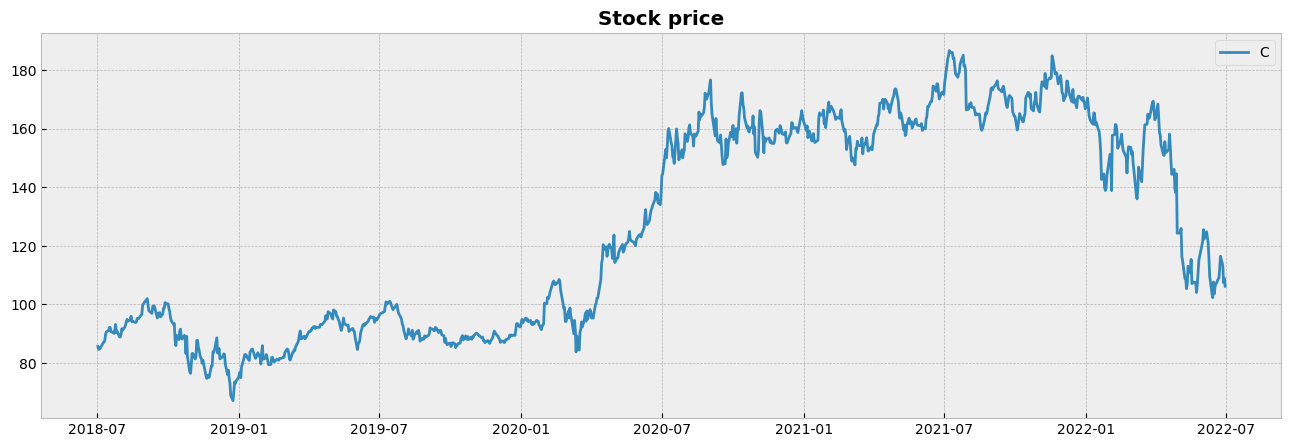

In [3]:
# построим график котировок цен акций на момент закрытия торгов
fig = plt.figure(figsize=(16, 5))

plt.plot(prices['Close'])
plt.legend('Close')

plt.title("Stock price", weight="bold")

plt.show()

In [4]:
# предобработаем данные
prices.index = prices.index.to_period(freq='d')
price = prices['Close']
dX = price.diff() 
ret_log = np.log(price).diff()
ret = price.pct_change() 
ret = ret.dropna()
ret

Date
2018-07-03   -0.011565
2018-07-05    0.003406
2018-07-06    0.006413
2018-07-09    0.016596
2018-07-10    0.002329
                ...   
2022-06-24    0.035752
2022-06-27   -0.027821
2022-06-28   -0.051404
2022-06-29    0.014153
2022-06-30   -0.024881
Freq: D, Name: Close, Length: 1006, dtype: float64

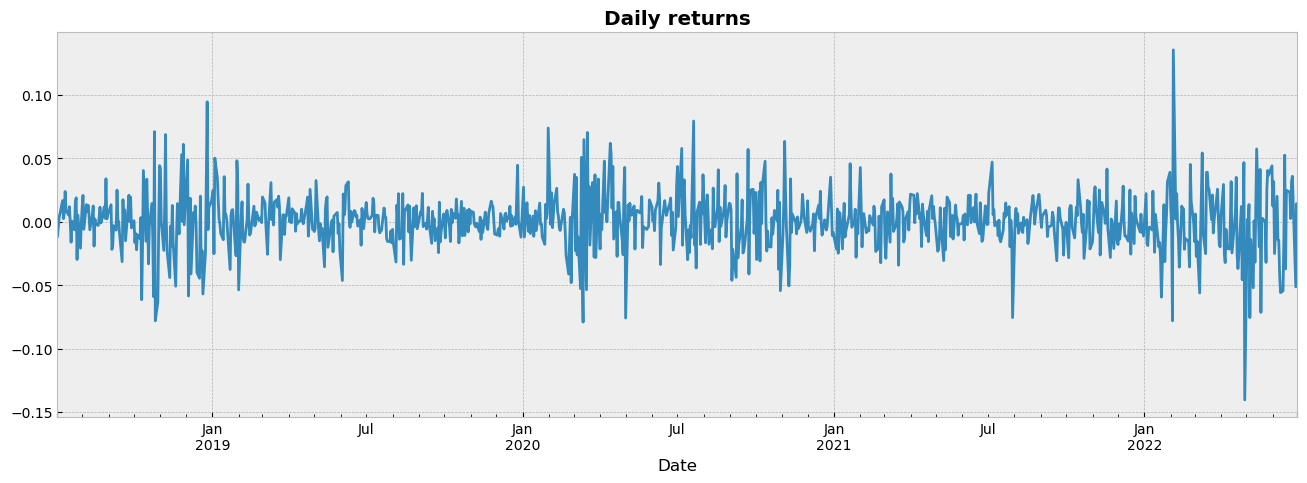

In [5]:
# построим график дневных доходностей
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

In [6]:
alpha = 0.05

# Модель GARCH с константным средним (constant mean), FIGARCH(1,1,2) и распределением Стьюдента для остатков
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()
    
    # обучаем модель
    mdl = arch_model(scaling_const * returns,
                     mean='Constant', lags=1, 
                     vol='FIGARCH', p=1, q=1, power=2, 
                     dist='t')

    res = mdl.fit(update_freq=0, disp='off')
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    q = mdl.distribution.ppf(alpha, res.params[-1:])
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    return VaR_garch_forecast

# Обратное Гауссовское распределение
def calculate_norminvgauss(ret, alpha=0.05):

    mu, sigma, skewness, kurtosis = norminvgauss.fit(ret) 
    var_curve = norminvgauss.ppf(alpha, mu, sigma, skewness, kurtosis)
    
    return var_curve

# Комбинация GARCH и EVT
def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    # обучаем модель 
    mdl = arch_model(scaling_const * returns,
                     mean='Constant', lags=1, 
                     vol='FIGARCH', p=1, q=1, power=2, 
                     dist='t')

    res = mdl.fit(disp='off')

   # получаем стандартизированные остатки
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


   # предсказываем среднее и десперсию на один шаг вперед
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # получаем предсказанные условные доходности
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const
    
    u = conditional_sr.quantile(0.2)
    ret_tail = conditional_sr[conditional_sr <= u]
    
    params_genpareto = ss.genpareto.fit(-ret_tail, loc=0)
    c, loc, scale = params_genpareto
    VaR_genpareto = u - scale / c * ((alpha/(conditional_sr <= u).mean())**(-c) - 1)

    return VaR_genpareto

# VaR за определённый период
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [7]:
# Вычисления значений для каждой модели
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)
VaR_norminvgauss = calc_VaR(ret, calculate_norminvgauss, L_history=252, level=alpha)
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

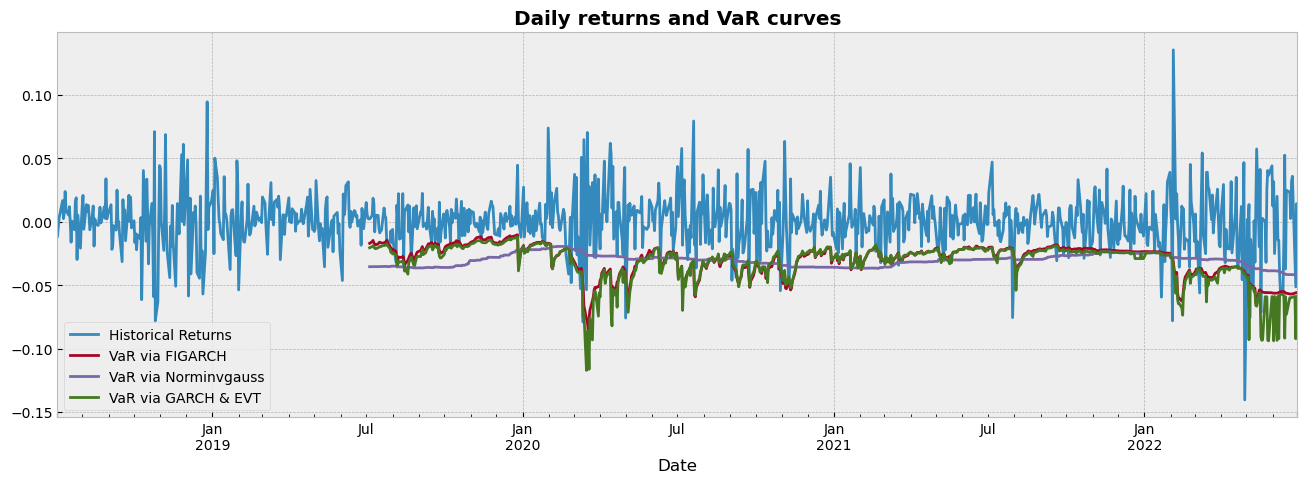

In [8]:
# график исторических значений и трёх VaR кривых
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_garch.plot()
VaR_norminvgauss.plot()
VaR_FHS.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via FIGARCH',
            'VaR via Norminvgauss',
            'VaR via GARCH & EVT'])

plt.show()

## Бектестирование VaR

In [9]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def backtest_VaR(r, VaR, level, L=None):
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [10]:
backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_norminvgauss, 1-alpha)
backtest_VaR(ret, VaR_FHS, 1-alpha)

Backtesting calculate_VaR_garch:
The proportion of hits is 6.76% instead of expected 5.0%
Two-sided p-val 0.0297, one-sided: 0.0196
yellow zone

Backtesting calculate_norminvgauss:
The proportion of hits is 6.5% instead of expected 5.0%
Two-sided p-val 0.0654, one-sided: 0.0396
green zone

Backtesting calculate_VaR_FHS:
The proportion of hits is 5.84% instead of expected 5.0%
Two-sided p-val 0.278, one-sided: 0.166
green zone



# Заключение

Наиболее подходящим подходом для акции Amazon является комбинация комбинация GARCH и EVT, так как данная модель наиболее удачно проявила себя при бектестировании. GARCH и EVT и обратное Гауссовское распределение в результате тестирования оказались в зелёной зоне, а GARCH модель в жёлтой. У модели GARCH&EVT меньший процент пробоев, что может говорить о том, что модель наиболее точная в отличие от обратного Гауссовского распределения.